In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
%matplotlib inline
plt.tight_layout()
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.6f' % x)
import datetime

from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, f1_score, precision_score
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder, StandardScaler

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

<Figure size 432x288 with 0 Axes>

In [2]:
train_filename = '/Users/Xiaotong Mu/Downloads/historical_data.csv'
train=pd.read_csv(train_filename, parse_dates = ['created_at','actual_delivery_time'])
test_filename = '/Users/Xiaotong Mu/Downloads/predict_data.csv'
test = pd.read_csv(test_filename, parse_dates = ['created_at'])
#combine train and test to run certain operations on both datasets together.
full = [train, test]

#### Data description #### 
The attached file `historical_data.csv` contains a subset of deliveries received at DoorDash in early 2015 in a subset of the cities. Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below. Note all money (dollar) values given in the data are in cents and all time duration values given are in seconds 
The target value to predict here is the total seconds value between `created_at` and `actual_delivery_time`. 

We have added noise to the dataset to obfuscate certain business details. Both `historical_data.csv` and `data_to_predict.json` include similar noise. We will only be evaluating your model's performance on this noisy, artificial dataset. The baseline model we will compare it was also trained and evaluated on the same noisy dataset.

#### Columns in historical_data.csv

### Time features
market_id: A city/region in which DoorDash operates, e.g., Los Angeles, given in the data as an id
created_at: Timestamp in UTC when the order was submitted by the consumer to DoorDash. (Note this timestamp is in UTC, but in case you need it, the actual timezone of the region was US/Pacific)
actual_delivery_time: Timestamp in UTC when the order was delivered to the consumer

### Store features 
store_id: an id representing the restaurant the order was submitted for
store_primary_category: cuisine category of the restaurant, e.g., italian, asian
order_protocol: a store can receive orders from DoorDash through many modes. This field represents an id denoting the protocol

### Order features
total_items: total number of items in the order
subtotal: total value of the order submitted (in cents)
num_distinct_items: number of distinct items included in the order
min_item_price: price of the item with the least cost in the order (in cents)
max_item_price: price of the item with the highest cost in the order (in cents)

### Market features
DoorDash being a marketplace, we have information on the state of marketplace when the order is placed, that can be used to estimate delivery time. The following features are values at the time of `created_at` (order submission time)
total_onshift_dashers: Number of available dashers who are within 10 miles of the store at the time of order creation 
total_busy_dashers: Subset of above `total_onshift_dashers` who are currently working on an order
total_outstanding_orders: Number of orders within 10 miles of this order that are currently being processed.

### Predictions from other models:
We have predictions from other models for various stages of delivery process that we can use.
estimated_order_place_duration: Estimated time for the restaurant to receive the order from DoorDash (in seconds)
estimated_store_to_consumer_driving_duration: Estimated travel time between store and consumer (in seconds)

In [3]:
#Preview data
train.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.000000,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.000000,4,3441,4,557,1239,33.000000,14.000000,21.000000,446,861.000000
1,2.000000,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.000000,1,1900,1,1400,1400,1.000000,2.000000,2.000000,446,690.000000
2,3.000000,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.000000,1,1900,1,1900,1900,1.000000,0.000000,0.000000,446,690.000000
3,3.000000,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.000000,6,6900,5,600,1800,1.000000,1.000000,2.000000,446,289.000000
4,3.000000,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.000000,3,3900,3,1100,1600,6.000000,6.000000,9.000000,446,650.000000


In [4]:
#The data tyoe for each feature
train.info()
print('_'*80)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     196441 non-null  float64       
 1   created_at                                    197428 non-null  datetime64[ns]
 2   actual_delivery_time                          197421 non-null  datetime64[ns]
 3   store_id                                      197428 non-null  int64         
 4   store_primary_category                        192668 non-null  object        
 5   order_protocol                                196433 non-null  float64       
 6   total_items                                   197428 non-null  int64         
 7   subtotal                                      197428 non-null  int64         
 8   num_distinct_items                            197428 n

In [5]:
train.dropna(axis=0,subset=['actual_delivery_time'],inplace=True)

In [6]:
#The data tyoe for each feature
print(train.isnull().sum())
print('_'*80)
test.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                0
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64
________________________________________________________________________________


market_id                                        250
created_at                                         0
store_id                                           0
store_primary_category                          1343
order_protocol                                   283
total_items                                        0
subtotal                                           0
num_distinct_items                                 0
min_item_price                                     0
max_item_price                                     0
total_onshift_dashers                           4633
total_busy_dashers                              4633
total_outstanding_orders                        4633
estimated_order_place_duration                     0
estimated_store_to_consumer_driving_duration      11
delivery_id                                        0
platform                                           0
dtype: int64

In [7]:
#Get difference between train and test columns
train_cols=train.columns
test_cols=test.columns
list(set(test_cols)-set(train_cols))

['delivery_id', 'platform']

In [8]:
#Drop the columns that are not in the training set
test.drop(['platform'],axis=1,inplace= True)

In [9]:
print('Training dataset has {} rows, {} columns'.format(train.shape[0],train.shape[1]))
print('Test dataset has {} rows, {} columns'.format(test.shape[0],test.shape[1]))

Training dataset has 197421 rows, 16 columns
Test dataset has 54778 rows, 16 columns


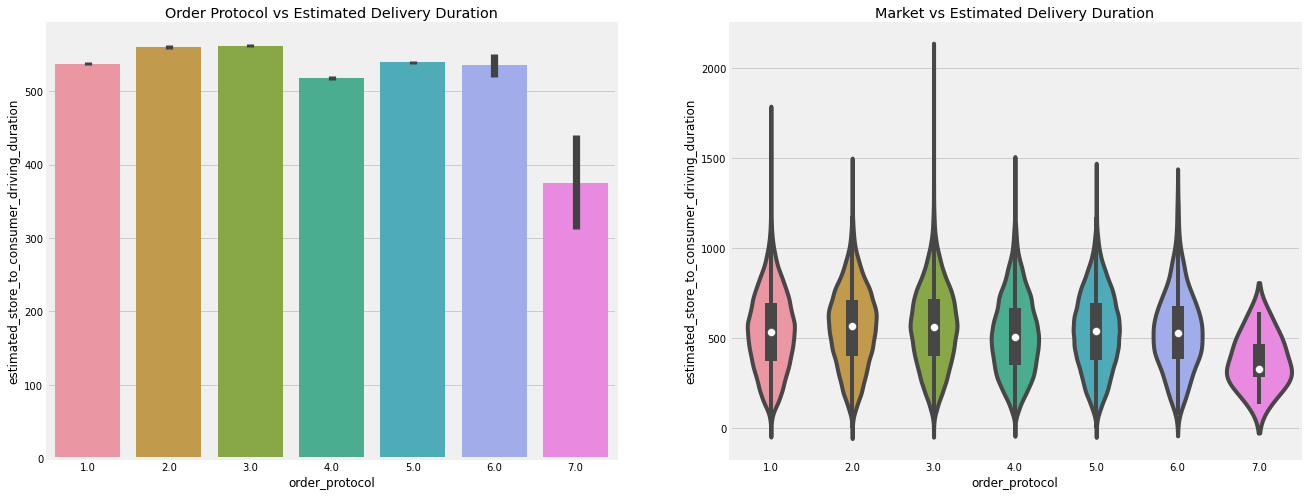

In [10]:
# estimated_store_to_consumer_driving_duration contains 11 missing values in the training dataset
f,ax=plt.subplots(1,2,figsize=(20,8))
sns.barplot('order_protocol','estimated_store_to_consumer_driving_duration',data=train,ax=ax[0])
ax[0].set_title('Order Protocol vs Estimated Delivery Duration')
sns.violinplot(x='order_protocol',y='estimated_store_to_consumer_driving_duration',data=train,ax=ax[1])
ax[1].set_title('Market vs Estimated Delivery Duration')
plt.close(2)
plt.show()

In [11]:
train['total_delivery_duration'] = (train['actual_delivery_time'] - train['created_at']).dt.seconds
train.drop(['actual_delivery_time'],axis=1,inplace=True)

In [12]:
#convert the created_at timestamp from UTC to US/Pacific
for dataset in full:
    dataset['created_at_US/Pacific'] = dataset['created_at'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
    dataset.drop(['created_at'],axis=1, inplace=True)

### Cleaning Data
After looking at the head of the dataset, we already were able to notice some Nan values, therefore need to examine missing values further before continuing with analysis.

Looking into the nature of our dataset we can state further things: 
total_onshift_dashers is the number of available dashers who are within 10 miles of the store at the time of order creation. If there were no dashers for that store - number simply will not exist, same logics apply to 'total_busy_dashers', and ' total_outstanding_orders' . 

For 'total_onshift_dashers ','total_busy_dashers', and ' total_outstanding_orders' we can simply append it with 0.0 for missing values

As mentioned in the data description, total_busy_dashers is a subset of `total_onshift_dashers` who are currently working on an order, so it should not be greater than the total_onshift_dashers. 

Create a new feature called 'total_available_dashers' based on 'total_onshift_dashers' and 'total_busy_dashers' to get the number of available(unbusy) dashers who are within 10 miles of the store at the time of order creation. 

In [13]:
#replace all NaN values in  'total_onshift_dashers ','total_busy_dashers', and ' total_outstanding_orders'  with 0
for dataset in full:
    dataset.fillna({'total_onshift_dashers':0, 'total_busy_dashers': 0, 'total_outstanding_orders': 0}, inplace=True)

In [14]:
for dataset in full:
    dataset['total_available_dashers'] = dataset.apply(lambda row: max(0, row['total_onshift_dashers'] - row['total_busy_dashers']), axis=1)

In [15]:
#Create a new feature called 'avg_value', based on subtotal and total_items to get the average value of each order
#The day of the week ranging from 0 to 6 where 0 denotes Monday and 6 denotes Sunday.
for dataset in full:
    dataset['avg_value'] = dataset['subtotal']/dataset['total_items']

In [16]:
#Create a new feature 'created_at_time','created_at_day', get the day from created at date. The day of the week with Monday=0, Sunday=6.
for dataset in full:
    dataset['created_at_hour'] = dataset['created_at_US/Pacific'].dt.hour
    dataset['created_at_month'] = dataset['created_at_US/Pacific'].dt.month
    dataset['created_at_dayofweek'] = dataset['created_at_US/Pacific'].dt.dayofweek

In [17]:
#replace many category with a more common name or classify them as other.
for dataset in full:
    dataset['store_primary_category'] = dataset['store_primary_category'].replace(['vegetarian'], 'vegan')
    dataset['store_primary_category'] = dataset['store_primary_category'].replace(['gastropub'], 'alcohol')
    dataset['store_primary_category'] = dataset['store_primary_category'].replace(['sushi'], 'japanese')
    dataset['store_primary_category'] = dataset['store_primary_category'].replace(['latin-american'], 'american')
    dataset['store_primary_category'] = dataset['store_primary_category'].replace(['dim-sum'], 'chinese')
cat=pd.DataFrame(train['store_primary_category'].value_counts())
cat_list=list(cat[cat['store_primary_category']<200].index.values)
for dataset in full:
    dataset['store_primary_category'].replace(cat_list,'rare',inplace=True)
    dataset['store_primary_category'].fillna('rare',inplace=True)    

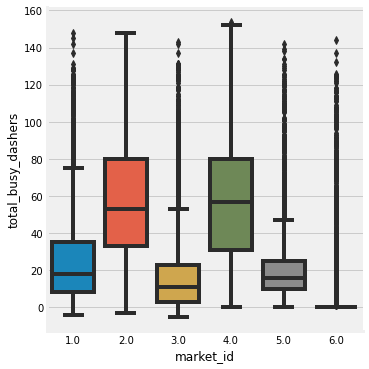

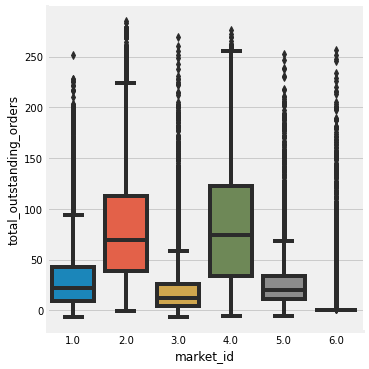

In [18]:
sns.factorplot(y='total_busy_dashers',x='market_id',data=train,kind='box')
sns.factorplot(y='total_outstanding_orders',x='market_id',data=train,kind='box')
#Market id column contain 987 missing values in trainning dataset.

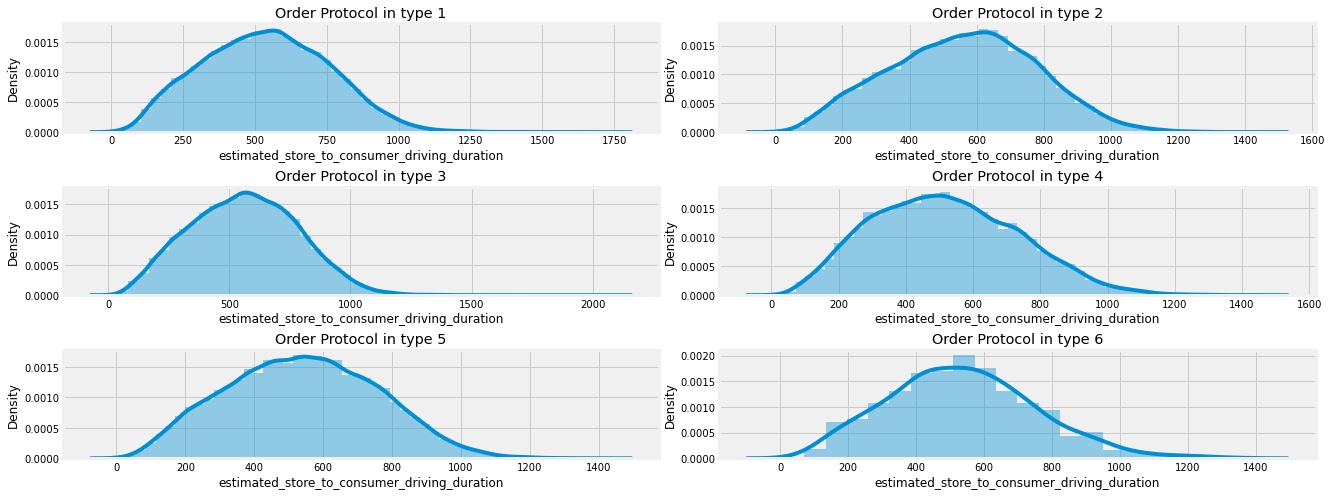

In [19]:
f,ax=plt.subplots(3,2,figsize=(20,8))
sns.distplot(train[train['order_protocol']==1].estimated_store_to_consumer_driving_duration,ax=ax[0][0])
ax[0][0].set_title('Order Protocol in type 1')
sns.distplot(train[train['order_protocol']==2].estimated_store_to_consumer_driving_duration,ax=ax[0][1])
ax[0][1].set_title('Order Protocol in type 2')
sns.distplot(train[train['order_protocol']==3].estimated_store_to_consumer_driving_duration,ax=ax[1][0])
ax[1][0].set_title('Order Protocol in type 3')
sns.distplot(train[train['order_protocol']==4].estimated_store_to_consumer_driving_duration,ax=ax[1][1])
ax[1][1].set_title('Order Protocol in type 4')
sns.distplot(train[train['order_protocol']==5].estimated_store_to_consumer_driving_duration,ax=ax[2][0])
ax[2][0].set_title('Order Protocol in type 5')
sns.distplot(train[train['order_protocol']==6].estimated_store_to_consumer_driving_duration,ax=ax[2][1])
ax[2][1].set_title('Order Protocol in type 6')

f.subplots_adjust(wspace=0.1,hspace=0.5)
plt.show()

In [20]:
cat_count = train[['store_primary_category', 'total_delivery_duration','subtotal','total_items']].groupby(train['store_primary_category']).agg({'store_primary_category': 'count', 'total_delivery_duration': 'mean','subtotal':'sum','total_items':'sum'}).sort_values(by='total_delivery_duration')
cat_count['avg_val']=cat_count['subtotal']/cat_count['total_items']
cat_count.sort_values(by=['total_delivery_duration','avg_val'])

,store_primary_category,total_delivery_duration,subtotal,total_items,avg_val
store_primary_category,,,,,
fast,7371,2631.216389,11736506,40441,290.213051
turkish,237,2666.506329,683948,743,920.522207
mexican,17098,2672.812083,39247595,54030,726.403757
smoothie,1659,2681.460518,3855644,4675,824.736684
sandwich,10059,2685.642112,21047026,28823,730.216355
breakfast,5425,2699.406636,12633190,15989,790.117581
alcohol,2034,2702.215831,5527541,6178,894.713661
hawaiian,1499,2719.557038,3018577,4346,694.564427
vietnamese,6095,2720.683675,13765960,16708,823.914293


                order_protocol  total_delivery_duration
order_protocol                                         
1.000000                 54723              2996.485207
2.000000                 24051              2841.872895
3.000000                 53197              2812.859485
4.000000                 19353              2905.859608
5.000000                 44289              2734.894782
6.000000                   794              3665.243073
7.000000                    19              2482.210526


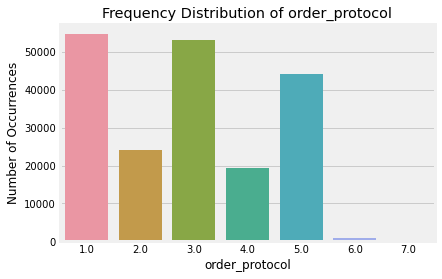

In [21]:
print(train[['order_protocol', 'total_delivery_duration']].groupby(train['order_protocol']).agg({'order_protocol':'count', 'total_delivery_duration':'mean'}))

order_protocol_count = train['order_protocol'].value_counts()
sns.countplot('order_protocol',data=train)
plt.title('Frequency Distribution of order_protocol')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('order_protocol', fontsize=12)
plt.show()

for dataset in full:
    dataset['order_protocol'].fillna(train.order_protocol.mode()[0],inplace=True)

In [22]:
train[['market_id', 'total_delivery_duration']].groupby(train['market_id']).agg({'market_id':'count', 'total_delivery_duration':'mean'})
for dataset in full:
    dataset['market_id'].fillna(train.market_id.mode()[0],inplace=True)

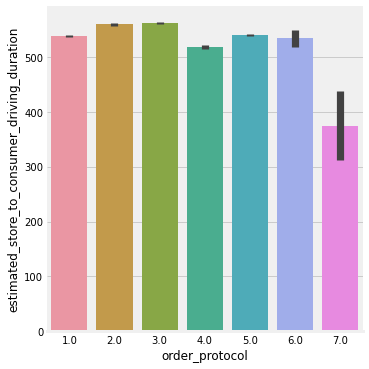

In [23]:
# Explore order_protocol vs estimated_store_to_consumer_driving_duration
g = sns.factorplot(x='order_protocol', y='estimated_store_to_consumer_driving_duration',data=train,kind="bar")
g.despine(left=True)
g = g.set_ylabels("estimated_store_to_consumer_driving_duration")

In [24]:
#Fillna driving duration 
for dataset in full:
    dataset['estimated_store_to_consumer_driving_duration'] = train['order_protocol'].mean()

In [25]:
print(train.isnull().sum())
print('_'*80)
test.isnull().sum()

market_id                                       0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
total_delivery_duration                         0
created_at_US/Pacific                           0
total_available_dashers                         0
avg_value                                       0
created_at_hour                                 0
created_at_month                                0


market_id                                       0
store_id                                        0
store_primary_category                          0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
delivery_id                                     0
created_at_US/Pacific                           0
total_available_dashers                         0
avg_value                                       0
created_at_hour                                 0
created_at_month                                0


In [26]:
test.loc[test['estimated_store_to_consumer_driving_duration'].isnull()]

,market_id,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,...,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,delivery_id,created_at_US/Pacific,total_available_dashers,avg_value,created_at_hour,created_at_month,created_at_dayofweek


,created_at_month,total_delivery_duration
created_at_month,,
1,1.000000,2779.362839
2,2.000000,2911.084902
10,10.000000,49659.000000


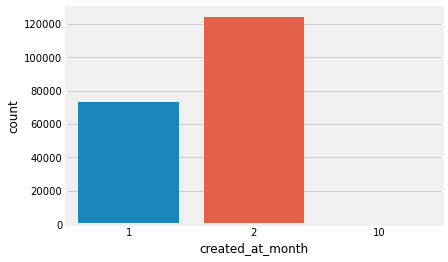

In [27]:
sns.countplot(x='created_at_month',data=train)
train[['created_at_month','total_delivery_duration']].groupby(train['created_at_month']).mean()

In [28]:
for dataset in full:
    dataset['estimated_delivery_duration'] = dataset['estimated_order_place_duration']+dataset['estimated_store_to_consumer_driving_duration']

In [29]:
#DataFrame Summary
pd.DataFrame({'unicos':train.nunique(),
                        'missing':train.isna().sum(),
                         'tipo':train.dtypes})

,unicos,missing,tipo
market_id,6,0,float64
store_id,6743,0,int64
store_primary_category,44,0,object
order_protocol,7,0,float64
total_items,57,0,int64
subtotal,8368,0,int64
num_distinct_items,20,0,int64
min_item_price,2312,0,int64
max_item_price,2652,0,int64
total_onshift_dashers,172,0,float64


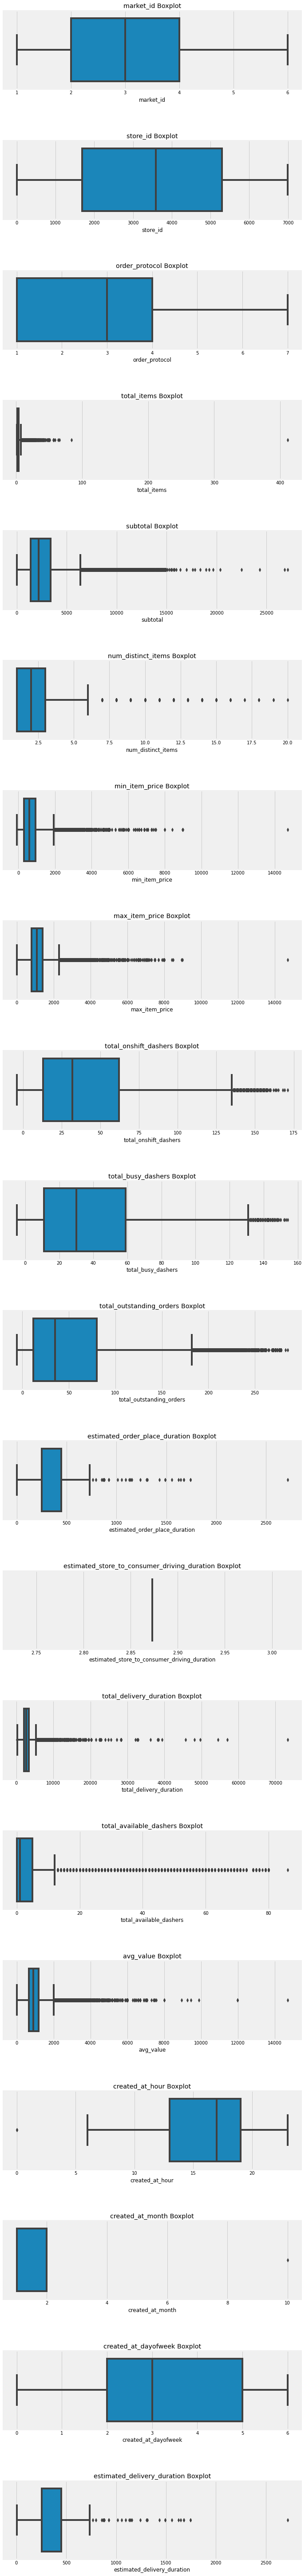

In [30]:
cols=train.select_dtypes(include=['int64','float64']).columns

fig,axs = plt.subplots(nrows=len(cols), ncols=1,figsize=(10,20))
fig.tight_layout()
plt.subplots_adjust(top=4)
for i in range(len(cols)):
    ax=sns.boxplot(x=train[cols[i]],ax=axs[i])
    ax.set_title(cols[i] + ' Boxplot')
plt.show()


In [31]:
# #Encoding: Converting categorical feature to ordinal
# cat_count = train[['store_primary_category', 'total_delivery_duration']].groupby(train['store_primary_category']).mean().sort_values(by='total_delivery_duration')
# label=cat_count.index
# replace_map = {k:v for k,v in zip(label, list(range(1,len(label)+1)))}
# print(replace_map)

In [32]:
#One Hot Encoding
# creating one hot encoder object 
enc = OneHotEncoder()
#reshape the 1-D country array to 2-D as fit_transform expects 2-D and finally fit the object 
train_X= enc.fit_transform(train['store_primary_category'].values.reshape(-1,1)).toarray()
#To add this back into the original dataframe 
train_OneHot = pd.DataFrame(train_X, columns = ["Category_"+str(int(i)) for i in range(train.store_primary_category.nunique())])
train = pd.concat([train.reset_index(drop=True), train_OneHot.reset_index(drop=True)], axis=1)
#droping the country column 
train.drop(['store_primary_category'], axis=1,inplace=True)
#printing to verify 
train.head()


,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,...,Category_34,Category_35,Category_36,Category_37,Category_38,Category_39,Category_40,Category_41,Category_42,Category_43
0,1.000000,1845,1.000000,4,3441,4,557,1239,33.000000,14.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2.000000,5477,2.000000,1,1900,1,1400,1400,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3.000000,5477,1.000000,1,1900,1,1900,1900,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3.000000,5477,1.000000,6,6900,5,600,1800,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,3.000000,5477,1.000000,3,3900,3,1100,1600,6.000000,6.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
test_X=enc.fit_transform(test.store_primary_category.values.reshape(-1,1)).toarray()
test_OneHot = pd.DataFrame(test_X, columns = ["Category_"+str(int(i)) for i in range(test.store_primary_category.nunique())])
test = pd.concat([test, test_OneHot], axis=1)
#droping the country column 
test.drop(['store_primary_category'], axis=1, inplace=True) 


Text(0.5, 1.0, 'Created At Hour count')

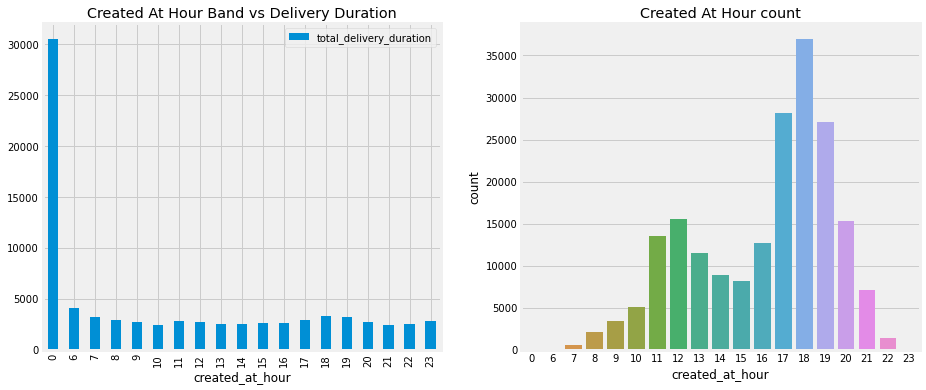

In [34]:
#Completing a numerical continuous feature
f,ax=plt.subplots(1,2,figsize=(14,6))
train[['created_at_hour','total_delivery_duration']].groupby(['created_at_hour']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Created At Hour Band vs Delivery Duration')
sns.countplot('created_at_hour',data=train,ax=ax[1])
ax[1].set_title('Created At Hour count')

In [35]:
full=[train,test]
for dataset in full:
    dataset.drop(['created_at_US/Pacific', 'estimated_order_place_duration','estimated_store_to_consumer_driving_duration', 'store_id','min_item_price','total_onshift_dashers'], axis=1,inplace=True)

In [36]:
band_list =['max_item_price','total_items','total_available_dashers']
    
for col in band_list:
    train[col+'_band'], bins = pd.qcut(train[col], 6, labels=False, duplicates='drop', retbins=True)
    bins = np.concatenate(([-np.inf], bins[1:-1], [np.inf]))
    test[col+'_band'] = pd.cut(test[col],bins,labels=False)
for dataset in full:
    dataset.drop(band_list, axis=1, inplace=True)

Text(0.5, 1.05, 'Pearson Correlation of Features')

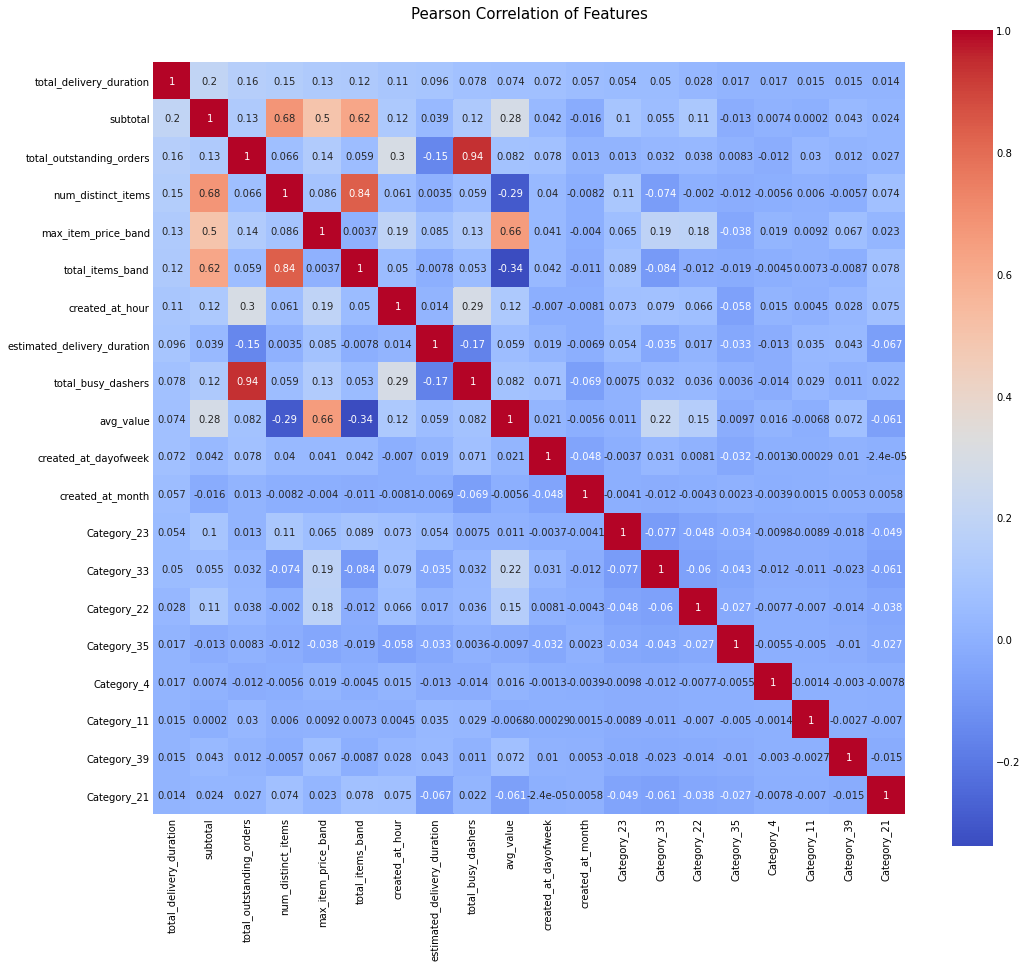

In [37]:
#Get Correlation between different variables
corr = train.corr(method='pearson').sort_values(by='total_delivery_duration', ascending=False).head(20)
col_list = corr.index
corr=corr[col_list]
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot=True,cmap='coolwarm',square=True)
plt.title('Pearson Correlation of Features',y=1.05, size=15)

In [38]:
#Model, Predict and Solve
from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import explained_variance_score, median_absolute_error, r2_score, mean_squared_error, accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE

#### Feature Importance in Gradient Boosting
A benefit of using gradient boosting is that after the boosted trees are constructed, it is relatively straightforward to retrieve importance scores for each attribute.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

This importance is calculated explicitly for each attribute in the dataset, allowing attributes to be ranked and compared to each other.

In [39]:
# Define dictionary to store our rankings
cols=train.drop('total_delivery_duration',axis=1).columns
from sklearn.preprocessing import MinMaxScaler
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

[11:26:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


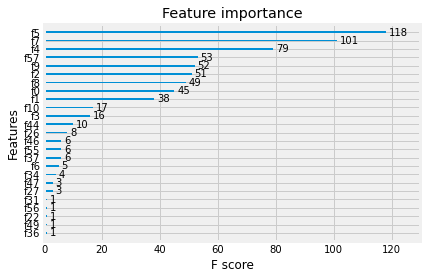

In [40]:
from xgboost import plot_importance
from matplotlib import pyplot

X = train.drop('total_delivery_duration', axis=1).values
y = train['total_delivery_duration'].values
# fit model no training data
model = XGBRegressor()
model.fit(X, y)
# plot feature importance
plot_importance(model)
plt.show()


In [41]:
ranks["XGBR"] = ranking(model.feature_importances_, cols)

In [42]:
# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), cols)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), cols)

In [43]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X,y)
ranks["RF"] = ranking(rf.feature_importances_, cols)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 50building tree 2 of 50building tree 3 of 50

building tree 4 of 50building tree 5 of 50


building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.0s


building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   44.6s finished


In [44]:
Feature_Ranking=pd.DataFrame(ranks)
Feature_Ranking['Mean Ranking']=Feature_Ranking.mean(axis=1)

#### Creating the Feature Ranking Matrix
We combine the scores from the various methods above and output it in a matrix form for convenient viewing as such:

In [45]:
Feature_Ranking.sort_values(by='Mean Ranking',ascending=False)
Feature_Ranking.reset_index(inplace=True)

In [46]:
Feature_Ranking.sort_values(by='Mean Ranking',inplace=True,ascending=False)
Selected_Features=list(Feature_Ranking['index'][:40])

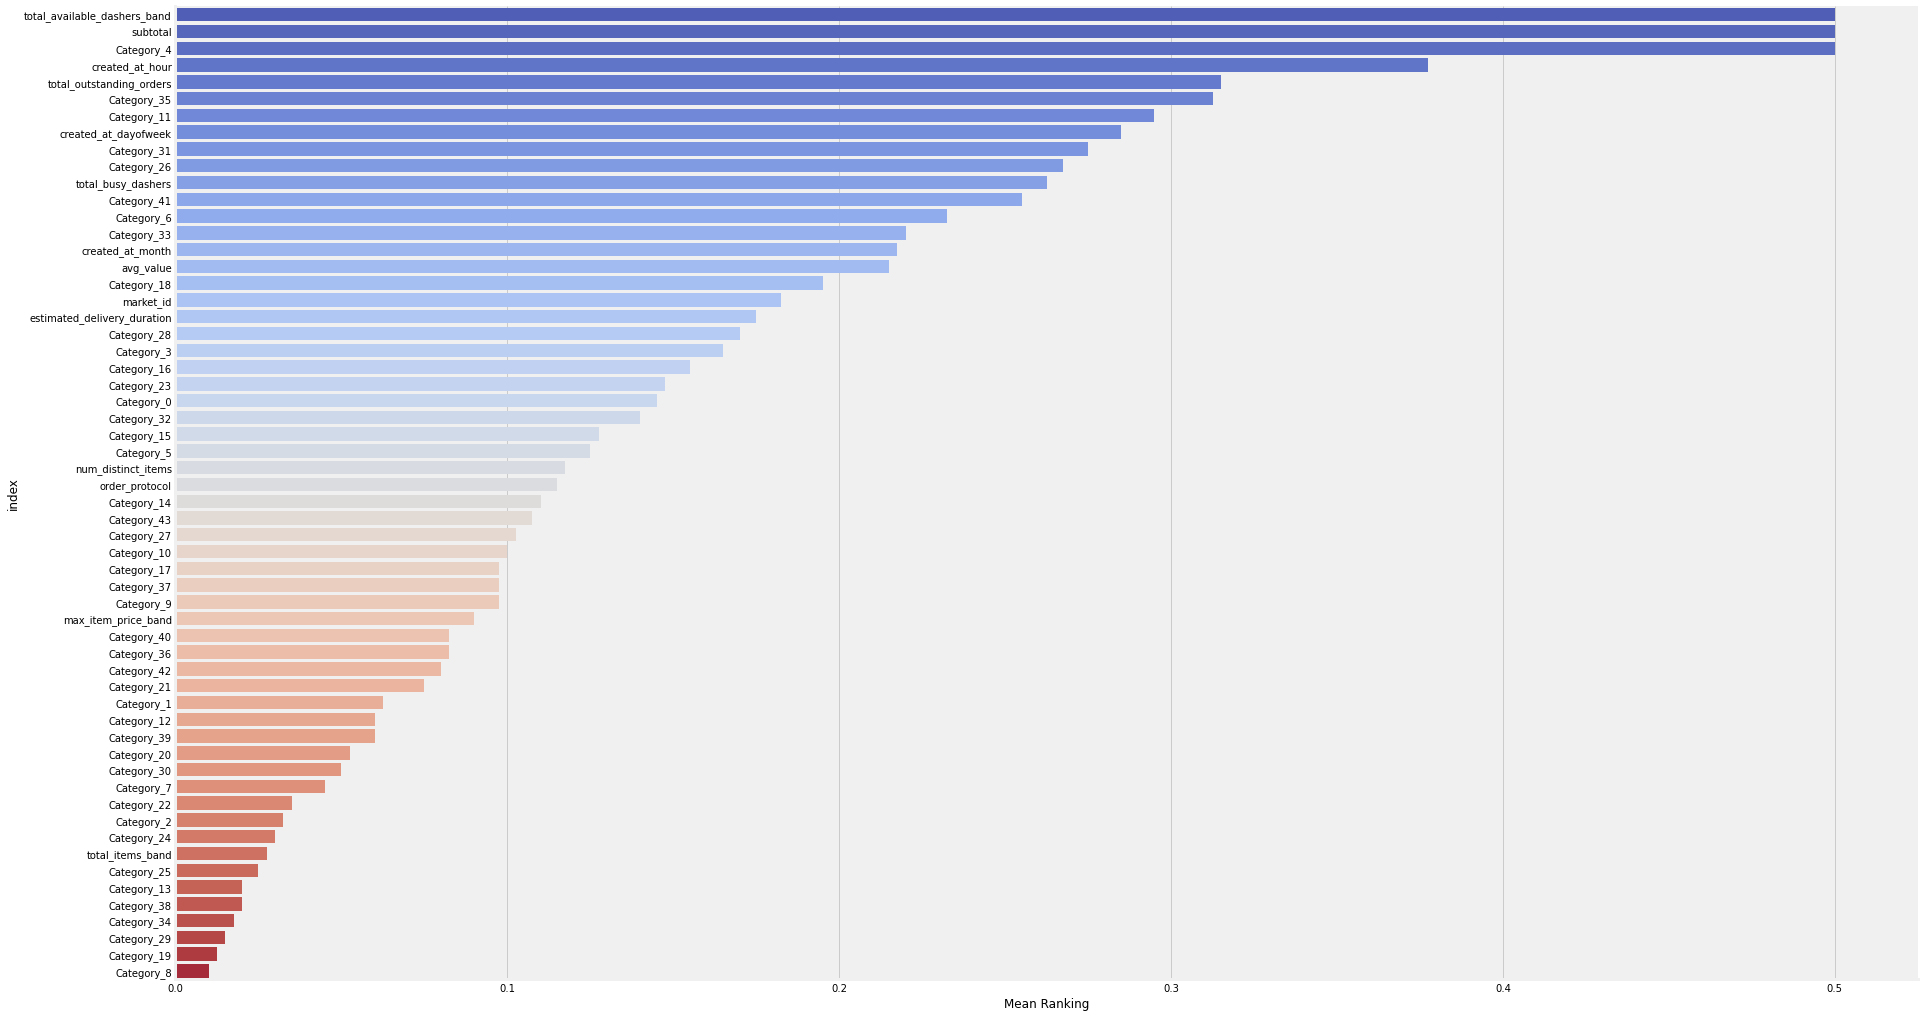

In [47]:
# Plot the ranking of the features
sns.catplot(x="Mean Ranking", y="index", data = Feature_Ranking, kind='bar', size=14, aspect=1.9, palette='coolwarm')

#### Fit with Selected Features

In [48]:
Selected_Features.append('total_delivery_duration')

X = train.drop(Selected_Features, axis=1).values
y = train['total_delivery_duration'].values

In [49]:
# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=3)

There are 3 most common metrics for evaluating predictions on regression machine learning problems:

Mean Absolute Error (MAE): This measures the absolute average distance between the real data and the predicted data, but it fails to punish large errors in prediction.
Use mean squared error when you want to penalize more bigger errors versus smaller errors, this because the square of a big number is way bigger than the one of a smaller number

Mean Square Error (MSE): This measures the squared average distance between the real data and the predicted data. Here, larger errors are well noted (better than MAE). But the disadvantage is that it also squares up the units of data as well. So, evaluation with different units is not at all justified.

In [50]:
# Creating the pipeline with the models to we do a first evaluate of their power to this problem

pipelines = []
seed = 2

pipelines.append(
                ("Scaled_Ridge", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Ridge", Ridge( tol=10 ))
                      ]))
                )
pipelines.append(
                ("Scaled_Lasso", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", Lasso( tol=1))
                      ]))
                )
pipelines.append(
                ("Scaled_Elastic", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", ElasticNet())
                      ]))
                )

pipelines.append(
                ("Scaled_SVR",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("SVR",  SVR())
                 ])
                )
                )

pipelines.append(
                ("Scaled_RF_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("RF", RandomForestRegressor())
                 ])
                )
                )

pipelines.append(
                ("Scaled_ET_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ET", ExtraTreesRegressor())
                 ])
                )
                )
pipelines.append(
                ("Scaled_BR_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BaggingRegressor())
                 ]))) 

pipelines.append(
                ("Scaled_Hub-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("Hub-Reg", HuberRegressor())
                 ]))) 
pipelines.append(
                ("Scaled_BayRidge",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BayesianRidge())
                 ]))) 

pipelines.append(
                ("Scaled_XGB_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("XGBR", XGBRegressor())
                 ]))) 

# pipelines.append(
#                 ("Scaled_DT_reg",
#                  Pipeline([
#                      ("Scaler", StandardScaler()),
#                      ("DT_reg", DecisionTreeRegressor())
#                  ]))) 

pipelines.append(
                ("Scaled_KNN_reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("KNN_reg", KNeighborsRegressor())
                 ])))


pipelines.append(
                ("Scaled_Gboost-Reg",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("GBoost-Reg", GradientBoostingRegressor())
                 ])))

pipelines.append(
                ("Scaled_RFR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", RandomForestRegressor())
                 ])))

pipelines.append(
                ("Scaled_XGBR_PCA",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("PCA", PCA(n_components=3)),
                     ("XGB", XGBRegressor())
                 ])))

#'neg_mean_absolute_error', 'neg_mean_squared_error','r2'
scoring = 'neg_mean_absolute_error'
n_folds = 3

MAE_results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=-1)    
    names.append(name)
    MAE_results.append(cv_results)    
    msg = "%s: %f (+/- %f)" % (name, cv_results.mean(),  cv_results.std())
    print(msg)
    

Scaled_Ridge: -814.063113 (+/- 3.796803)
Scaled_Lasso: -814.072767 (+/- 3.801364)
Scaled_Elastic: -815.564422 (+/- 3.713639)
Scaled_SVR: -798.855481 (+/- 3.931154)
Scaled_RF_reg: -813.957154 (+/- 3.769147)
Scaled_ET_reg: -813.937249 (+/- 3.765396)
Scaled_BR_reg: -813.962194 (+/- 3.772819)
Scaled_Hub-Reg: -797.340590 (+/- 4.330109)
Scaled_BayRidge: -814.076057 (+/- 3.794279)
Scaled_XGB_reg: -813.904246 (+/- 3.769096)
Scaled_KNN_reg: -881.332815 (+/- 3.202305)
Scaled_Gboost-Reg: -813.900517 (+/- 3.766782)
Scaled_RFR_PCA: -817.014417 (+/- 2.616043)
Scaled_XGBR_PCA: -815.804837 (+/- 3.911709)


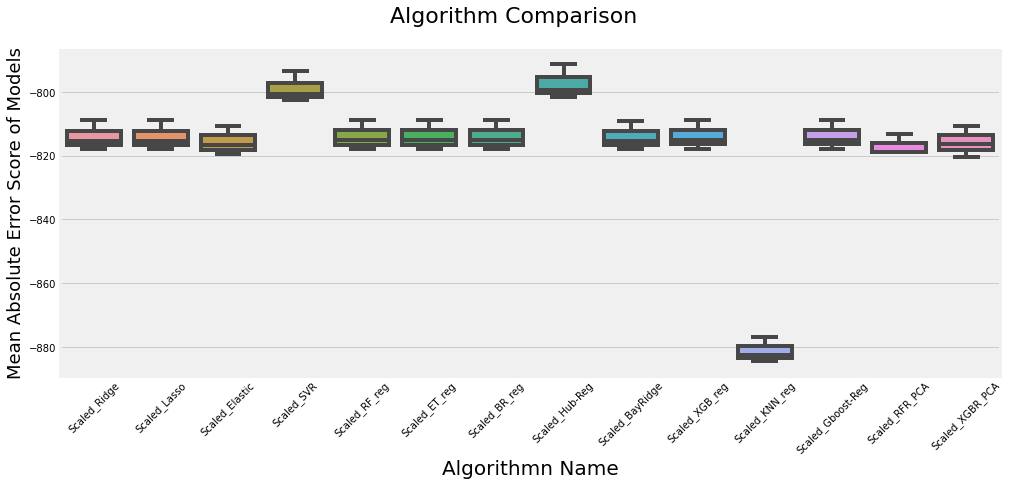

In [51]:
# boxplot algorithm comparison
model_perf = pd.DataFrame(np.transpose(MAE_results),columns=names)
fig = plt.figure(figsize=(15,6))
fig.suptitle('Algorithm Comparison', fontsize=22)
ax = fig.add_subplot(111)
sns.boxplot(data=model_perf)
ax.set_xticklabels(names)
ax.set_xlabel("Algorithmn Name", fontsize=20)
ax.set_ylabel("Mean Absolute Error Score of Models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [52]:
Selected_Features.append('total_delivery_duration')

X = train.drop('total_delivery_duration', axis=1).values
y = train['total_delivery_duration'].values

In [53]:
# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=3)

In [54]:
# Selected Five models and fit with complete features
# Scaled_SVR, Scaled_RF_reg, Scaled_Hub_Reg, Scaled_XGB_reg, Scaled_Gboost_Reg
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
test_copy  = test.drop("delivery_id", axis=1).copy()
X_test = sc.transform (X_test)
test_copy = sc.transform(test_copy)

In [55]:
from operator import sub
Late={}
def Lateness(y_pred,y,model_name):
    y_pred=list(y_pred)
    len_pred=len(y_pred)
    diff=map(sub,y_pred,y) #negative: arrived early, positive late
    diff=list(map(lambda x: max(x,0),diff))
    gre5 = sum(i/60>5 for i in diff)/len_pred*100
    gre10= sum(i/60>10 for i in diff)/len_pred*100
    print(f'Greater than 5 mins late: {gre5}%')
    print(f'Greater than 10 mins late: {gre10}%')
    Late[model_name]=[gre5,gre10]

In [56]:
#Scaled_SVR
svr= SVR(kernel='linear', verbose=2)
svr.fit(X_train,y_train)
y_hat=svr.predict(X_test)


[LibSVM]

In [57]:
Lateness(y_hat,y_test,'SVR')
R2=svr.score(X_test,y_test)*100
print(f'SVR Prediction R2-score:{R2}')
Late['SVR'].append(R2)

Greater than 5 mins late: 34.56502469292136%
Greater than 10 mins late: 19.949347853615297%
SVR Prediction R2-score:12.820611813293725


In [58]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores

#Using Random Search to find the best Hyper Paramns
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}



In [59]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

#Knowning the best params
rf_random.best_params_

# Predicting with best params
y_hat_Search = rf_random.predict(X_test)

# Printing the difference between the 2 models scores
# print("XGBoost Regressor R2-score: {}".format(round(r2_score(y_hat, y_test),4)))
# print("RandomForest Regressor Prediction R2-score: {}".format(round(r2_score(y_hat_Search, y_test),4)))
# print("\nMSE of XGBoost Regressor: {}".format(median_absolute_error(y_hat, y_test)))
# print("MSE of RandomForest Regressor: {} ".format(median_absolute_error(y_hat_Search, y_test)))


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 34.4min finished


In [60]:
Lateness(y_hat_Search,y_test,'RandomForestRegressor')
print(f'RandomForestRegressor Prediction R2-score:{r2_score(y_hat_Search, y_test)}')
Late['RandomForestRegressor'].append(r2_score(y_hat_Search, y_test))

Greater than 5 mins late: 42.150183614030645%
Greater than 10 mins late: 26.18209446625301%
RandomForestRegressor Prediction R2-score:-2.8269340128780547


In [61]:
#HuberRegressor
hub_reg = HuberRegressor()
hub_reg.fit(X_train,y_train)
y_hat_hub = hub_reg.predict(X_test)

In [62]:
Lateness(y_hat_hub,y_test,'HuberRegressor')
print(f'HuberRegressor Prediction R2-score:{hub_reg.score(X_test,y_test)*100}')
Late['HuberRegressor'].append(hub_reg.score(X_test, y_test))

Greater than 5 mins late: 36.451817145751555%
Greater than 10 mins late: 21.772825123464607%
HuberRegressor Prediction R2-score:13.974077145473906


In [63]:
#Scaled XGBRegressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [64]:
xgb.fit(X_train, y_train)

[14:29:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.08, max_depth=7, subsample=0.75)

In [65]:
y_hat_xgb = xgb.predict(X_test)

In [66]:
#XGBRgressor
Lateness(y_hat_xgb,y_test,'XGBRegressor')
print(f'XGBRegressor Prediction R2-score:{xgb.score(X_test,y_test)*100}')
Late['XGBRegressor'].append(xgb.score(X_test, y_test))

Greater than 5 mins late: 41.26630365961758%
Greater than 10 mins late: 25.346334050905405%
XGBRegressor Prediction R2-score:25.020660949545935


In [67]:
#GradientBoostingRegressor
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
y_hat_gb = gb.predict(X_test)


In [68]:
Lateness(y_hat_gb,y_test,'GradientBoostingRegressor')
print(f'GBRegressor Prediction R2-score:{gb.score(X_test,y_test)*100}')
Late['GradientBoostingRegressor'].append(gb.score(X_test, y_test))

Greater than 5 mins late: 42.70988983158161%
Greater than 10 mins late: 26.815246296061794%
GBRegressor Prediction R2-score:20.611198674141427


In [69]:
pd.DataFrame.from_dict(Late,orient='index',columns=['% Greater than 5 mins','% Greater than 10 mins','R2 Score'])

,% Greater than 5 mins,% Greater than 10 mins,R2 Score
SVR,34.565025,19.949348,12.820612
RandomForestRegressor,42.150184,26.182094,-2.826934
HuberRegressor,36.451817,21.772825,0.139741
XGBRegressor,41.266304,25.346334,0.250207
GradientBoostingRegressor,42.709890,26.815246,0.206112


In [70]:
y_hat=svr.predict(test_copy)

In [71]:
submission = pd.DataFrame({
        "delivery_id": test["delivery_id"],
        "predicted duration": y_hat
    })

In [72]:
import os

outname = 'data_to_predict.csv'

outdir = './dir'
if not os.path.exists(outdir):
    os.mkdir(outdir)

fullname = os.path.join(outdir, outname)    
submission.to_csv(fullname,index = False,header=True)